In [87]:
import json
import matplotlib.pyplot as plt
import pandas as pd

## Load the data

In [88]:
# Clusters
clusters = pd.read_csv('data/processed/clusters_with_stats.csv')
clusters.head()

,CLUSTER_,CORE REL EXPR_mean,CORE REL EXPR_std,SEQ_unique
0,0,0.129612,0.017409,"AATTTA,AATTCT,AATTCA,AACTTA,AAATCC,AATATG,AATA..."
1,1,0.229000,NaN,ATCCGC
2,2,0.123416,0.014622,"ACCTAC,ACCTCC,ACATCC,ACATCA,ACATAC,AAATCA,ATAT..."
3,3,0.052767,0.008386,"CGTTCC,CGTCCC,CGTCAC"
4,4,0.104843,0.013261,"CCGAAA,CCGAAT,CCGTGA,CTGCCT,CCGGAC,CAAGTC,CCGG..."


In [89]:
# uASPIre
uaspire = pd.read_csv('data/raw/uASPIre_RBS_300k_r1.csv', sep='\t', usecols=['RBS', 'IFP480', 'total_reads'])

# Get the number of records
print(f'Originally {len(uaspire)} rows')

# Remove rows with total_reads < 50
uaspire = uaspire[uaspire['total_reads'] >= 1000].reset_index(drop=True)
print(f'After removing records with low number of reads {len(uaspire)} rows')

uaspire.head()

Originally 303503 rows
After removing records with low number of reads 25444 rows


,RBS,IFP480,total_reads
0,TAAGGATACTTACGCAC,0.62508,27829
1,ACTCTGGATGTAATGTG,0.15903,25038
2,ATCATCGCAAGCTGCGT,0.03045,24443
3,TGAAAGCGGGGTTCCTA,0.45974,21946
4,TTTAGAGGAACGAACAT,0.76043,18985


## Locate the core in the uASPIre dataset

### Transform the clusters dataset so we have core sequence and associated cluster and mean

In [90]:
df_exploded = clusters.assign(SEQ_unique=clusters['SEQ_unique'].str.split(',')).explode('SEQ_unique')
seq_expr_dict = dict(zip(df_exploded['SEQ_unique'].str.strip(), df_exploded['CORE REL EXPR_mean']))

### For each RBS in the uaspire dataset, find the strongest core

In [91]:
def find_best_seq(rbs, seq_expr_dict):
    max_val = None
    best_seq = None
    for cut in range(5, 9):  # remove 5 to 9 chars
        trimmed = rbs[:-cut] if cut < len(rbs) else ''
        if len(trimmed) >= 6:
            candidate = trimmed[-6:]
            val = seq_expr_dict.get(candidate)
            if val is not None and (max_val is None or val > max_val):
                max_val = val
                best_seq = candidate
    return best_seq, max_val

# Apply to DataFrame
uaspire[['best_seq', 'best_expr']] = uaspire['RBS'].apply(
    lambda r: pd.Series(find_best_seq(r, seq_expr_dict))
)

uaspire.head()

,RBS,IFP480,total_reads,best_seq,best_expr
0,TAAGGATACTTACGCAC,0.62508,27829,GGATAC,0.208820
1,ACTCTGGATGTAATGTG,0.15903,25038,TGGATG,0.626600
2,ATCATCGCAAGCTGCGT,0.03045,24443,GCAAGC,0.173730
3,TGAAAGCGGGGTTCCTA,0.45974,21946,GCGGGG,0.894928
4,TTTAGAGGAACGAACAT,0.76043,18985,AGGAAC,0.919315


## Evaluate

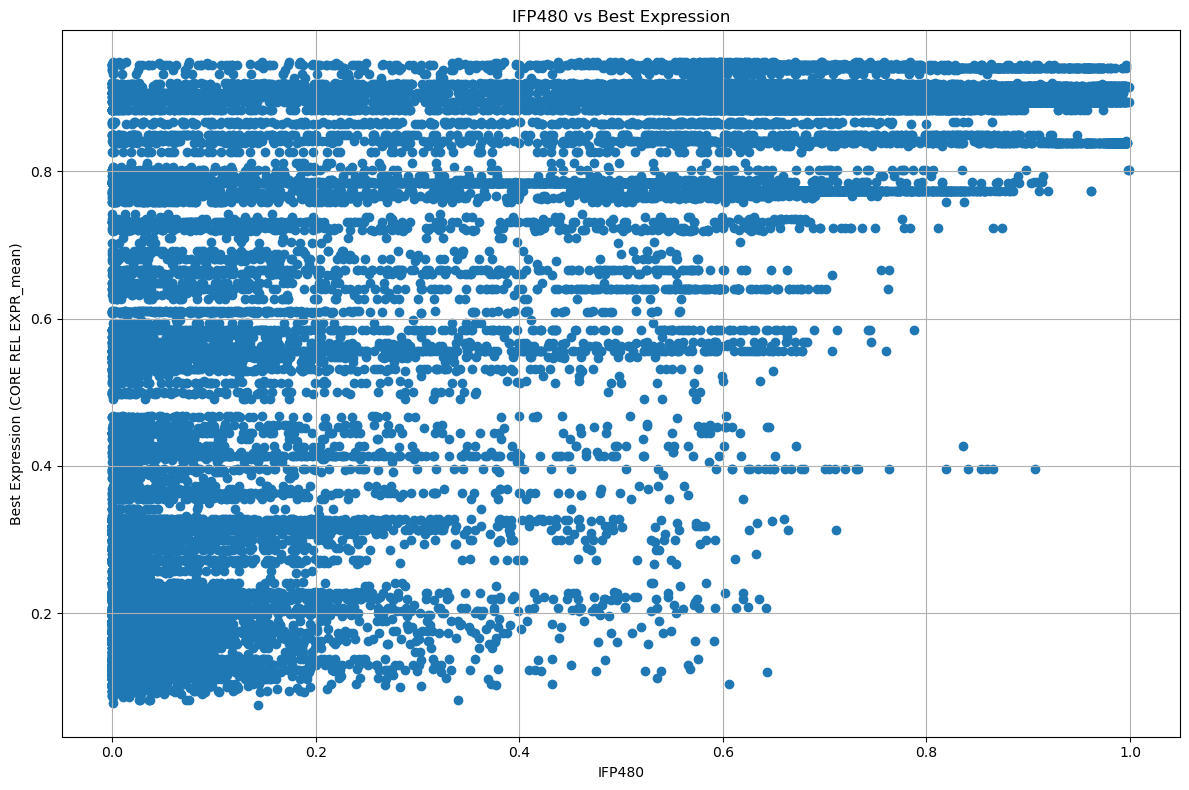

In [92]:
# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(uaspire['IFP480'], uaspire['best_expr'])
plt.xlabel('IFP480')
plt.ylabel('Best Expression (CORE REL EXPR_mean)')
plt.title('IFP480 vs Best Expression')
plt.grid(True)
plt.tight_layout()
plt.show()

### Compare it with the non-cluster approach

In [93]:
# Load the EMOPEC data
emopec = json.load(open('data/interim/emopec_data.json'))

# Based on the best_seq, add the EMOPEC value
uaspire['EMOPEC'] = uaspire['best_seq'].apply(lambda x: emopec.get(x))

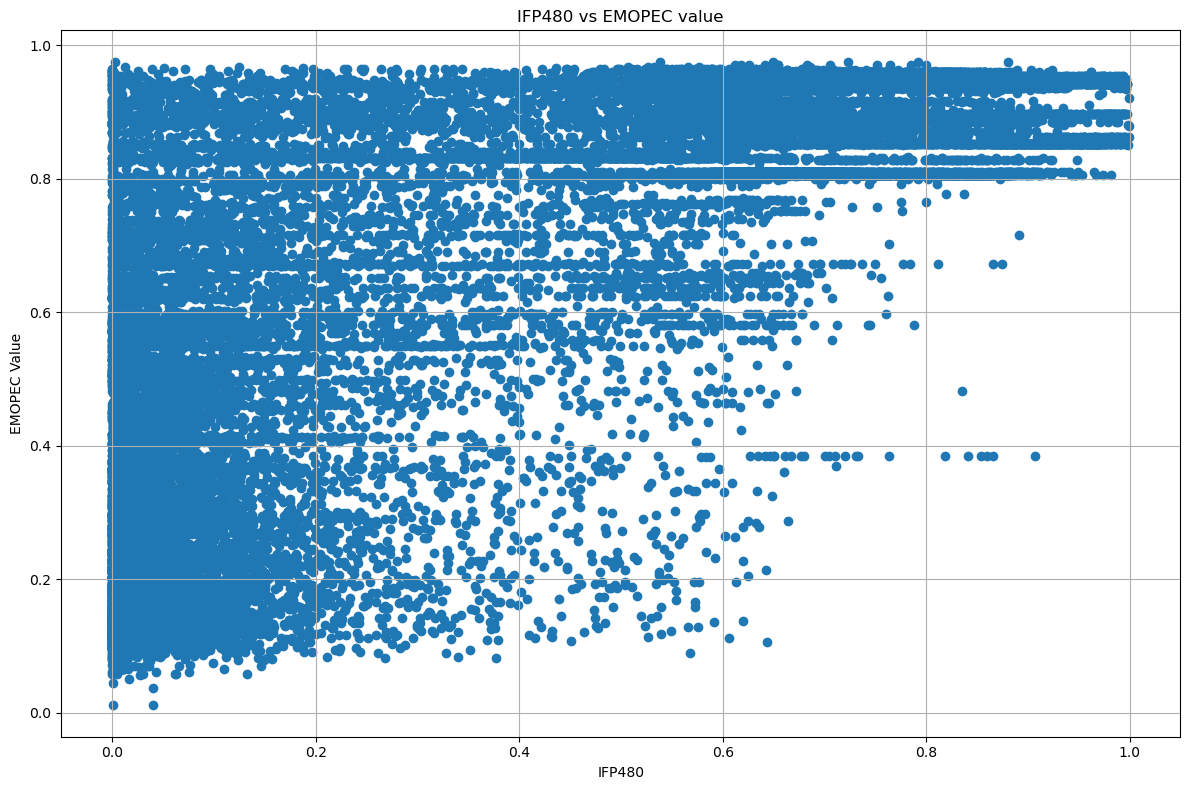

In [94]:
# Scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(uaspire['IFP480'], uaspire['EMOPEC'])
plt.xlabel('IFP480')
plt.ylabel('EMOPEC Value')
plt.title('IFP480 vs EMOPEC value')
plt.grid(True)
plt.tight_layout()
plt.show()